## 0. Constants and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uproot
from tqdm import tqdm
import sys,os
#My imports
import plotters,helpers,wienersvd

%load_ext autoreload
%autoreload 2

MEDULLA_DIR = '/exp/sbnd/app/users/brindenc/develop/medulla_area/medulla'

sys.path.append(MEDULLA_DIR)
from spineplot import utilities

plt.style.use(f'{MEDULLA_DIR}/spineplot/styles/numu2025.mplstyle')

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
SYST_DIR = '/exp/sbnd/data/users/brindenc/medulla/test/tmp_syst'
OUTPUT_DIR = os.path.join(SYST_DIR,'plots')
COV_OUTPUT_DIR = os.path.join(OUTPUT_DIR,'cov')
FRACUNC_OUTPUT_DIR = os.path.join(OUTPUT_DIR,'fracunc')
SMEARING_OUTPUT_DIR = os.path.join(OUTPUT_DIR,'smearing')

# Make the output directories
os.makedirs(OUTPUT_DIR,exist_ok=True)
os.makedirs(COV_OUTPUT_DIR,exist_ok=True)
os.makedirs(FRACUNC_OUTPUT_DIR,exist_ok=True)
os.makedirs(SMEARING_OUTPUT_DIR,exist_ok=True)

In [42]:
SYST_FILE = '/exp/sbnd/data/users/brindenc/medulla/test/output2.root'
SBRUCE_FILE = '/exp/sbnd/data/users/brindenc/medulla/test/numucc_incl_sys2.root'
FLUX_FILE = '/exp/sbnd/data/users/munjung/flux/sbnd_original_flux.root'

In [4]:
STATUS_LABEL = 'SBND Work-In-Progress'

In [5]:
RHO = 1.3836  #g/cm3, liquid Ar density
N_A = 6.02214076e23 # Avogadro’s number
M_AR = 39.95 # g, molar mass of argon
V_SBND = 380 * 380 * 440 # cm3, the fiducial volume of the detector 
NTARGETS = np.float64(RHO * V_SBND * N_A / M_AR)
print("# of targets: ", NTARGETS)

# of targets:  1.3251484770937053e+30


In [6]:
#WienerSVD params
C_type = 2
Norm_type = 0.5

## 1. Load data

In [7]:
all_csvs = [f for f in list(os.listdir(SYST_DIR)) if f.endswith('.csv')]
xsec_csvs = [f for f in all_csvs if 'GENIEReWeight' in f]
flux_csvs = [f for f in all_csvs if 'Flux' in f]
stat_csvs = [f for f in all_csvs if 'statistical' in f]
summary_csvs = [f for f in all_csvs if 'total_xsec' in f or 'flux' in f or 'all' in f]
summary_names = ['total_xsec', 'flux', 'all', 'stat']

variables = ['reco_leading_muon_costheta', 'reco_leading_muon_momentum_gev',
'true_leading_muon_costheta', 'true_leading_muon_momentum_gev']

len(all_csvs), len(xsec_csvs)+ len(flux_csvs)+ len(stat_csvs) + len(summary_csvs)

(1572, 1520)

In [8]:
# CV and bin edges are always the same
momentum_bin_edges = np.loadtxt(f'{SYST_DIR}/all_reco_leading_muon_momentum_gev_binedges.csv')
momentum_bin_centers = momentum_bin_edges[:-1] + np.diff(momentum_bin_edges) / 2
momentum_cv = np.loadtxt(f'{SYST_DIR}/all_reco_leading_muon_momentum_gev_cv.csv')

costheta_bin_edges = np.loadtxt(f'{SYST_DIR}/all_reco_leading_muon_costheta_binedges.csv')
costheta_bin_centers = costheta_bin_edges[:-1] + np.diff(costheta_bin_edges) / 2
costheta_cv = np.loadtxt(f'{SYST_DIR}/all_reco_leading_muon_costheta_cv.csv')

# Make dictionary of systematic names and their corresponding csv files
# all = Specific uncertainties
# summary = Total uncertainties, summary of each systematic

all_covs = dict()
all_frac_uncs = dict()

summary_covs = dict()
summary_frac_uncs = dict()

for csv in tqdm(all_csvs):
  csv_type = csv.split('_')[-1][:-4] # remove csv from end
  if csv_type != 'cov' and csv_type != 'fracuncs':
    continue
  if 'nsigma' in csv: #Skip nsigma
    continue
  name, var_name = helpers.extract_parameter_name(csv,variables)
  #Stat is a special case so is added to both dictionaries
  if name == 'stat':
    if csv_type == 'cov':
      cov = np.loadtxt(f'{SYST_DIR}/{csv}',delimiter=',')
      all_covs[name,var_name] = cov
      summary_covs[name,var_name] = cov
    elif csv_type == 'fracuncs':
      frac_uncs = np.loadtxt(f'{SYST_DIR}/{csv}',delimiter=',')
      all_frac_uncs[name,var_name] = frac_uncs
      summary_frac_uncs[name,var_name] = frac_uncs
  elif any(sum_name in name for sum_name in summary_names):
    if csv_type == 'cov':
      summary_covs[name,var_name] = np.loadtxt(f'{SYST_DIR}/{csv}',delimiter=',')
    elif csv_type == 'fracuncs':
      summary_frac_uncs[name,var_name] = np.loadtxt(f'{SYST_DIR}/{csv}',delimiter=',')
  else:
    if csv_type == 'cov':
      all_covs[name,var_name] = np.loadtxt(f'{SYST_DIR}/{csv}',delimiter=',')
    elif csv_type == 'fracuncs':
      all_frac_uncs[name,var_name] = np.loadtxt(f'{SYST_DIR}/{csv}',delimiter=',')


100%|██████████| 1572/1572 [01:03<00:00, 24.61it/s]


In [9]:
# Get the signal events 1d spectra
costheta_signal = pd.read_csv(f'{SYST_DIR}/signal/leading_muon_costheta_spectra1d.csv',index_col=0,header=0)
assert len(list(costheta_signal.index)) == len(costheta_bin_edges) - 1,\
  f'Number of bins in costheta signal ({len(list(costheta_signal.index))}) does not match number of bins in costheta bin edges ({len(costheta_bin_edges) - 1})'
costheta_signal = costheta_signal.values

momentum_signal = pd.read_csv(f'{SYST_DIR}/signal/leading_muon_momentum_gev_spectra1d.csv',index_col=0,header=0)
assert len(list(momentum_signal.index)) == len(momentum_bin_edges) - 1,\
  f'Number of bins in momentum signal ({len(list(momentum_signal.index))}) does not match number of bins in momentum bin edges ({len(momentum_bin_edges) - 1})'
momentum_signal = momentum_signal.values

In [10]:
# Get the background subtracted selected events
costheta_selected = pd.read_csv(f'{SYST_DIR}/selected_nobkg/leading_muon_costheta_spectra1d.csv',index_col=0,header=0)
assert len(list(costheta_selected.index)) == len(costheta_bin_edges) - 1,\
  f'Number of bins in costheta selected ({len(list(costheta_selected.index))}) does not match number of bins in costheta bin edges ({len(costheta_bin_edges) - 1})'
costheta_selected = costheta_selected.values

momentum_selected = pd.read_csv(f'{SYST_DIR}/selected_nobkg/leading_muon_momentum_gev_spectra1d.csv',index_col=0,header=0)
assert len(list(momentum_selected.index)) == len(momentum_bin_edges) - 1,\
  f'Number of bins in momentum selected ({len(list(momentum_selected.index))}) does not match number of bins in momentum bin edges ({len(momentum_bin_edges) - 1})'
momentum_selected = momentum_selected.values

In [11]:
#Get the efficiency values
costheta_eff = (costheta_selected/costheta_signal)
momentum_eff = (momentum_selected/momentum_signal)

/tmp/ipykernel_2123531/576832952.py:3: RuntimeWarning: invalid value encountered in divide
  momentum_eff = (momentum_selected/momentum_signal)


In [12]:
#Get the smearing matrices
costheta_smearing = pd.read_csv(f'{SYST_DIR}/leading_muon_costheta_spectra2d.csv',index_col=0,header=0)
assert len(list(costheta_smearing.index)) == len(list(costheta_smearing.columns)) == len(costheta_bin_edges) - 1,\
  f'Number of bins in costheta smearing matrix ({len(list(costheta_smearing.index))}) does not match number of bins in costheta bin edges ({len(costheta_bin_edges) - 1})'
#Just save the matrix
costheta_smearing = costheta_smearing.values 
# Convert to response matrix
costheta_response = helpers.convert_smearing_to_response(costheta_smearing,costheta_eff)

momentum_smearing = pd.read_csv(f'{SYST_DIR}/leading_muon_momentum_gev_spectra2d.csv',index_col=0,header=0)
assert len(list(momentum_smearing.index)) == len(list(momentum_smearing.columns)) == len(momentum_bin_edges) - 1,\
  f'Number of bins in momentum smearing matrix ({len(list(momentum_smearing.index))}) does not match number of bins in momentum bin edges ({len(momentum_bin_edges) - 1})'
#Just save the matrix
momentum_smearing = momentum_smearing.values 
# Convert to response matrix
momentum_response = helpers.convert_smearing_to_response(momentum_smearing,momentum_eff)

In [13]:
#Extract POT from the MC file
tree = uproot.open(f'{SYST_FILE}')['events/simulation']
POT = float(tree['POT;1'].values())

/tmp/ipykernel_2123531/597915379.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  POT = float(tree['POT;1'].values())


### Testing

In [44]:
sbruce_tree = uproot.open(SBRUCE_FILE)['events/simulation']
sbruce_tree.keys()

['POT;6',
 'POT;5',
 'POT;4',
 'POT;3',
 'POT;2',
 'POT;1',
 'Livetime;6',
 'Livetime;5',
 'Livetime;4',
 'Livetime;3',
 'Livetime;2',
 'Livetime;1',
 'selected1muX;1',
 'selected1muXCos;1',
 'selected1muXCos_none;1',
 'selected1muXNu;1',
 'selected1muXNu_none;1',
 'signal1muX;1']

In [46]:
_costheta = sbruce_tree['signal1muX;1'].arrays('reco_leading_muon_costheta',library='pd').values
print(np.isnan(_costheta).sum(),np.nanmin(_costheta),np.nanmax(_costheta))

_costheta = sbruce_tree['signal1muX;1'].arrays('true_leading_muon_costheta',library='pd').values
print(np.isnan(_costheta).sum(),np.nanmin(_costheta),np.nanmax(_costheta))

413 -0.9995574951171875 0.9996035099029541
0 -0.9984046220779419 0.9997199177742004


In [48]:
len(_costheta)

3724

In [64]:
start_end_keys = [
 'Run',
 'Subrun',
 'Evt',
 'true_leading_muon_end_x',
 'true_leading_muon_end_y',
 'true_leading_muon_end_z',
 'true_leading_muon_start_x',
 'true_leading_muon_start_y',
 'true_leading_muon_start_z',
 'reco_leading_muon_end_x',
 'reco_leading_muon_end_y',
 'reco_leading_muon_end_z',
 'reco_leading_muon_start_x',
 'reco_leading_muon_start_y',
 'reco_leading_muon_start_z']
keys = start_end_keys + ['true_category','reco_vertex_y','reco_flash_score']
_df = sbruce_tree['signal1muX;1'].arrays(keys,library='pd')
mask = np.isnan(_df.true_leading_muon_end_x.values) & ((_df.true_category.values == 0) | (_df.true_category.values == 1))
mask = np.isnan(_df.reco_leading_muon_end_x.values)
print(mask.sum(),_df.shape[0])
_df[mask].loc[:,['reco_leading_muon_start_y','true_leading_muon_start_y','reco_vertex_y']]

413 3724


,reco_leading_muon_start_y,true_leading_muon_start_y,reco_vertex_y
2,NaN,-119.882248,-119.250000
4,NaN,160.049957,NaN
24,NaN,-127.950012,-127.050018
33,NaN,-168.750000,NaN
55,NaN,-109.649979,NaN
...,...,...,...
3695,NaN,94.050018,NaN
3698,NaN,-24.750000,55.649994
3720,NaN,-184.350006,-184.200012
3721,NaN,-153.782257,-121.050003


### end testing

In [188]:
# Extract flux from the flux file
flux = uproot.open(FLUX_FILE)

# numu flux
numu_flux = flux["flux_sbnd_numu"].to_numpy()
bin_edges = numu_flux[1]
flux_vals = numu_flux[0]

# get integrated flux
integrated_flux = flux_vals.sum()
integrated_flux /= 1e4 # to cm2
INTEGRATED_FLUX = np.float64(integrated_flux * POT / 1e6) # POT
print("Integrated flux: %.3e" % INTEGRATED_FLUX)

Integrated flux: 1.215e+10


In [189]:
NTARGETS,INTEGRATED_FLUX

(np.float64(1.3251484770937053e+30), np.float64(12149992448.0))

In [190]:
XSEC_UNIT = 1/ (INTEGRATED_FLUX * NTARGETS)
print(f'Xsec unit: {XSEC_UNIT}')

Xsec unit: 6.210970267047006e-41


## 2. Quick plots for testing

### 2.1 Covariance matrices

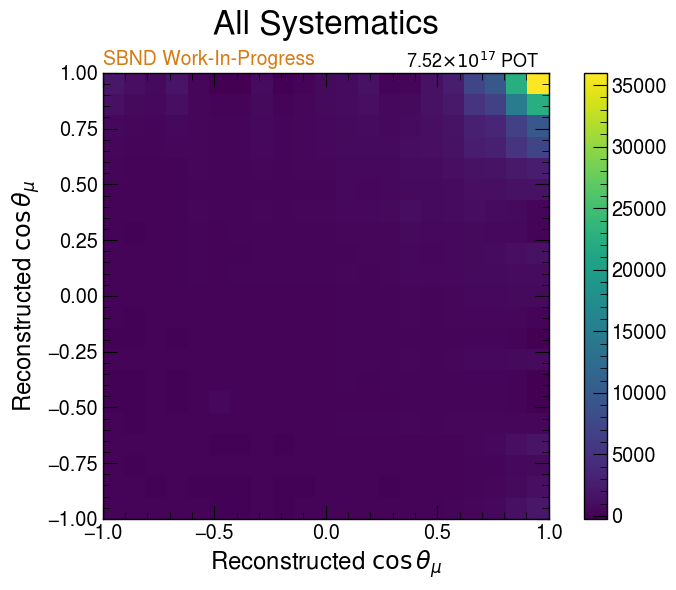

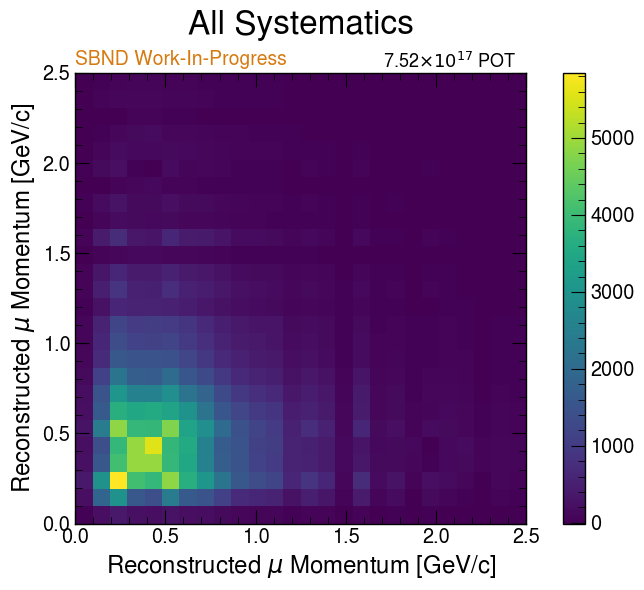

In [191]:
fig,ax = plotters.plot_square_with_bins(summary_covs['total_xsec','reco_leading_muon_costheta'],
  costheta_bin_edges,
  axis_labels=r'Reconstructed $\cos\theta_{\mu}$',
  title='All Systematics')
utilities.mark_pot(ax,POT,horizontal=True)
utilities.mark_preliminary(ax,STATUS_LABEL)
fig.savefig(f'{COV_OUTPUT_DIR}/reco_costheta_all.png')

fig,ax = plotters.plot_square_with_bins(summary_covs['total_xsec','reco_leading_muon_momentum_gev'],
  momentum_bin_edges,
  axis_labels=r'Reconstructed $\mu$ Momentum [GeV/c]',
  title='All Systematics')
utilities.mark_pot(ax,POT,horizontal=True)
utilities.mark_preliminary(ax,STATUS_LABEL)
fig.savefig(f'{COV_OUTPUT_DIR}/reco_momentum_all.png')

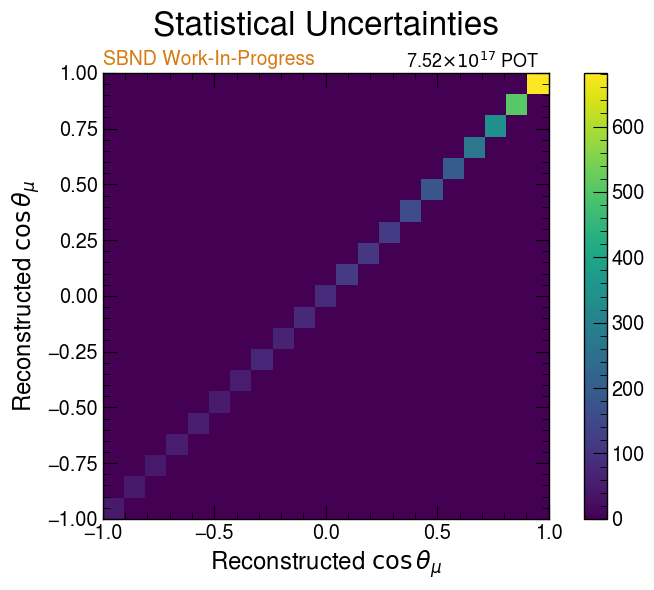

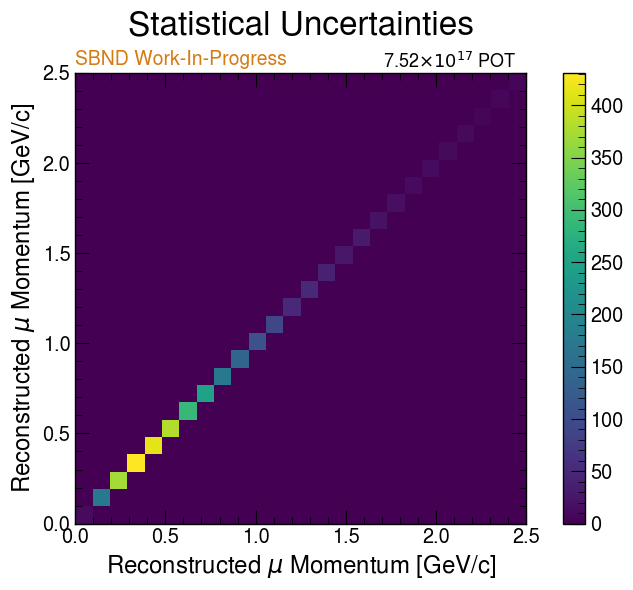

In [192]:
fig,ax = plotters.plot_square_with_bins(all_covs['stat','reco_leading_muon_costheta'],
  costheta_bin_edges,
  axis_labels=r'Reconstructed $\cos\theta_{\mu}$',
  title='Statistical Uncertainties')
utilities.mark_pot(ax,POT,horizontal=True)
utilities.mark_preliminary(ax,STATUS_LABEL)
fig.savefig(f'{COV_OUTPUT_DIR}/reco_costheta_stat.png')


fig,ax = plotters.plot_square_with_bins(all_covs['stat','reco_leading_muon_momentum_gev'],
  momentum_bin_edges,
  axis_labels=r'Reconstructed $\mu$ Momentum [GeV/c]',
  title='Statistical Uncertainties')
utilities.mark_pot(ax,POT,horizontal=True)
utilities.mark_preliminary(ax,STATUS_LABEL)
fig.savefig(f'{COV_OUTPUT_DIR}/reco_momentum_stat.png')

### 2.2 Fractional Uncertainties

In [193]:
def plot_frac_unc(frac_unc_dict,cv,binedges,plot_var,ax=None,fig=None,**pltkwargs):
  """
  Plot the fractional uncertainty from a dictionary of fractional uncertainties
  and the central values.
  """
  # Set up the figure and axes
  if fig is None and ax is None:
    fig, ax = plt.subplots(figsize=(8,6))
  elif fig is None:
    fig = ax.get_figure()
  elif ax is None:
    ax = fig.gca()

  # Collect data and calculate average fractional uncertainties
  plot_data = []
  for i,(name,var_name) in enumerate(frac_unc_dict.keys()):
    if var_name != plot_var:
      continue
    frac_unc = frac_unc_dict[name,var_name]
    avg_frac_unc = helpers.get_avg_fracunc(frac_unc,cv)
    plot_data.append((name, frac_unc, avg_frac_unc))

  # Sort by average fractional uncertainty in descending order
  plot_data.sort(key=lambda x: x[2], reverse=True)

  # Plot in sorted order
  for name, frac_unc, avg_frac_unc in plot_data:
    label = f'{name} ({avg_frac_unc:.2%})'
    plotters.plot_hist_edges(binedges,
      frac_unc,
      None,
      label,
      ax=ax)
  return fig,ax

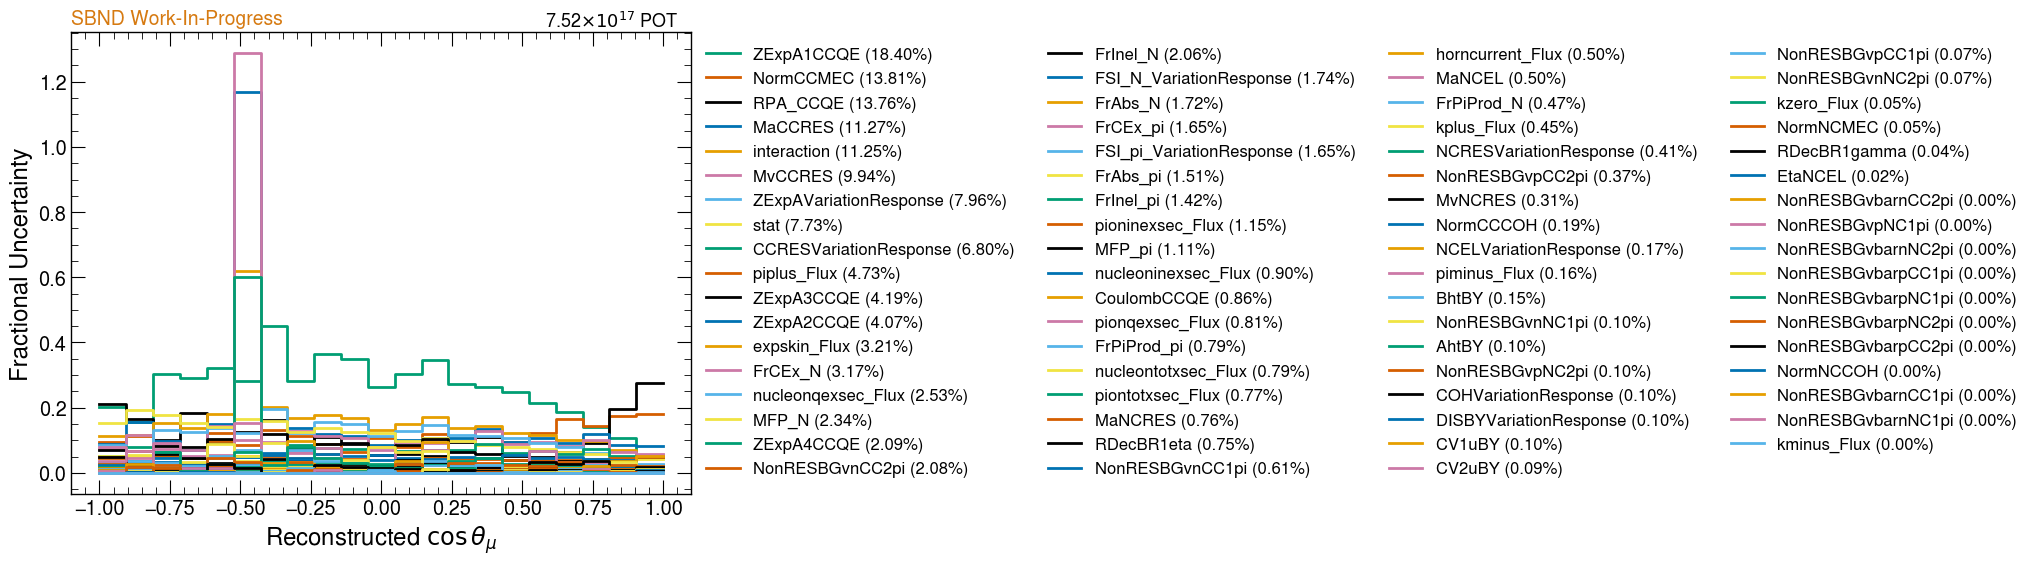

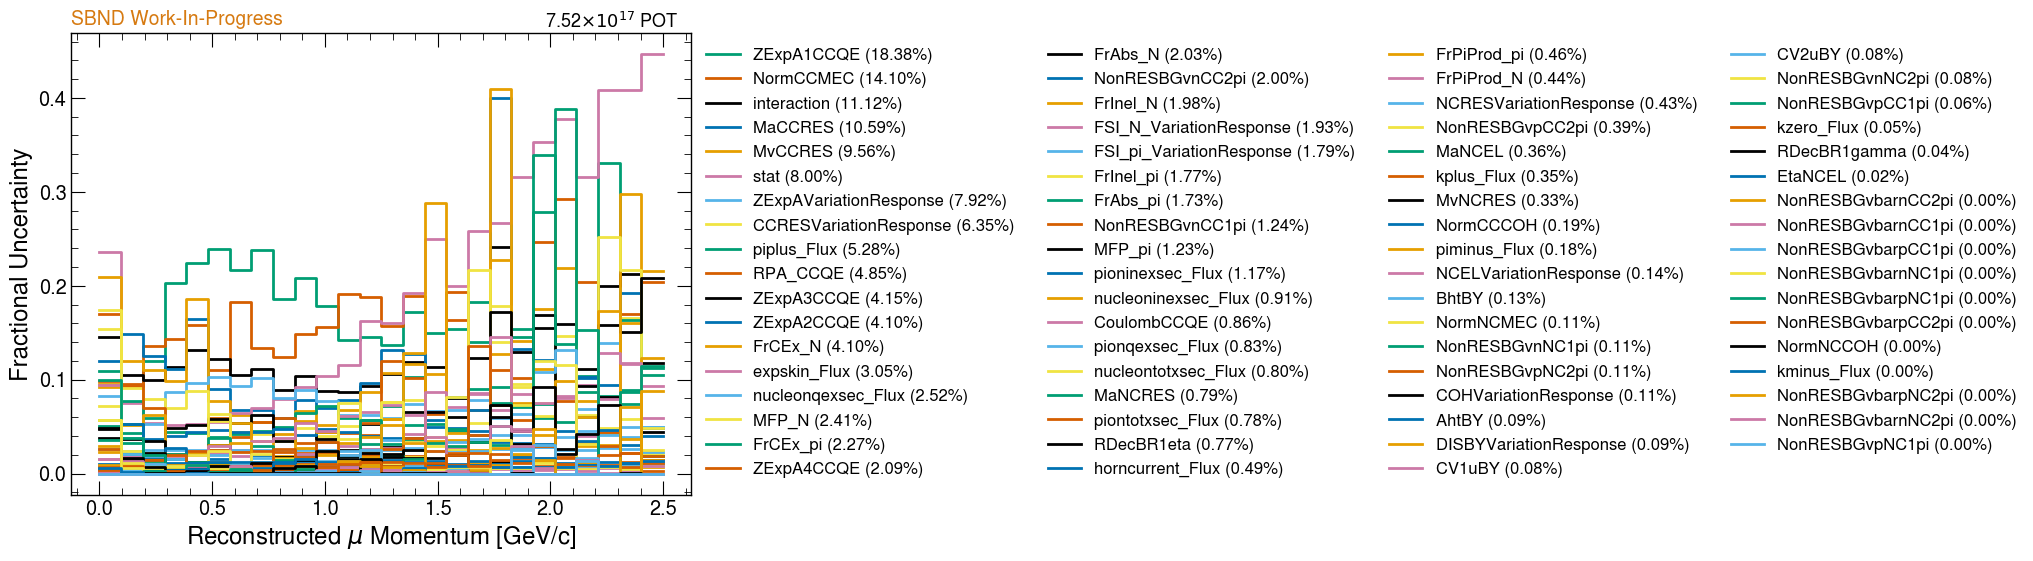

In [194]:
plot_var = 'reco_leading_muon_costheta'
fig, ax = plot_frac_unc(all_frac_uncs,costheta_cv,costheta_bin_edges,plot_var)

ax.legend(ncols=4,bbox_to_anchor=(1,1))
ax.set_xlabel(r'Reconstructed $\cos\theta_{\mu}$')
ax.set_ylabel('Fractional Uncertainty')
utilities.mark_pot(ax,POT,horizontal=True)
utilities.mark_preliminary(ax,STATUS_LABEL)
fig.savefig(f'{FRACUNC_OUTPUT_DIR}/reco_costheta_fracuncs.png',dpi=300)
plt.show()

plot_var = 'reco_leading_muon_momentum_gev'
fig, ax = plot_frac_unc(all_frac_uncs,momentum_cv,momentum_bin_edges,plot_var)

ax.legend(ncols=4,bbox_to_anchor=(1,1))
ax.set_xlabel(r'Reconstructed $\mu$ Momentum [GeV/c]')
ax.set_ylabel('Fractional Uncertainty')
utilities.mark_pot(ax,POT,horizontal=True)
utilities.mark_preliminary(ax,STATUS_LABEL)
fig.savefig(f'{FRACUNC_OUTPUT_DIR}/reco_momentum_fracuncs.png',dpi=300)
plt.show()
  

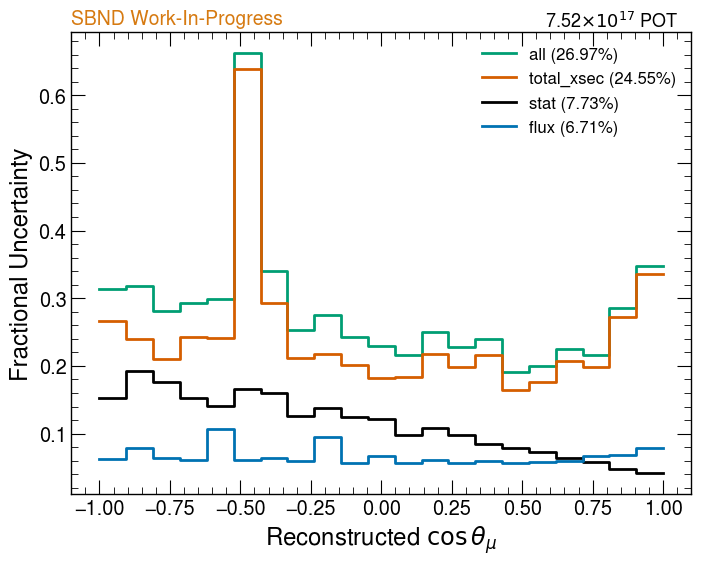

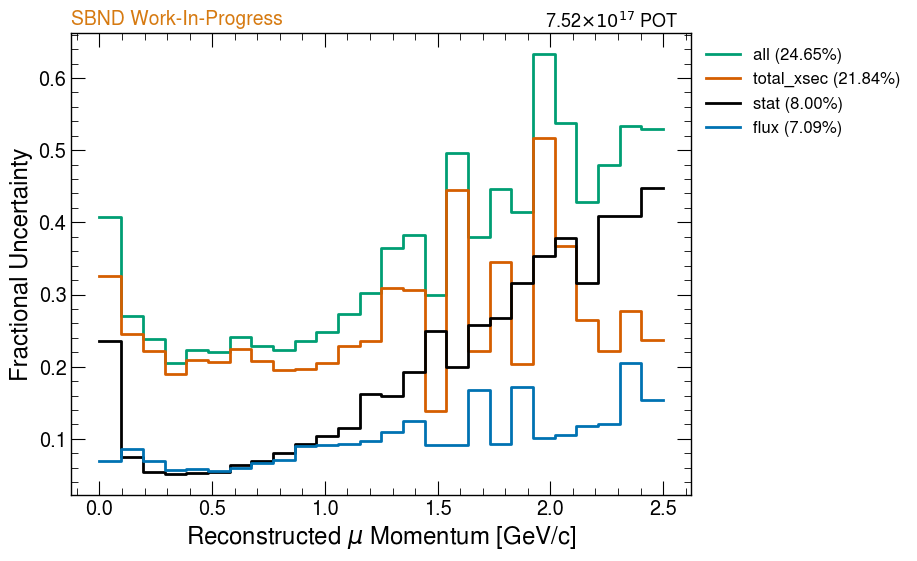

In [195]:
plot_var = 'reco_leading_muon_costheta'
fig, ax = plot_frac_unc(summary_frac_uncs,costheta_cv,costheta_bin_edges,plot_var)

ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel(r'Reconstructed $\cos\theta_{\mu}$')
ax.set_ylabel('Fractional Uncertainty')
utilities.mark_pot(ax,POT,horizontal=True)
utilities.mark_preliminary(ax,STATUS_LABEL)
fig.savefig(f'{FRACUNC_OUTPUT_DIR}/reco_costheta_summary_fracuncs.png',dpi=300)
plt.show()

plot_var = 'reco_leading_muon_momentum_gev'
fig, ax = plot_frac_unc(summary_frac_uncs,momentum_cv,momentum_bin_edges,plot_var)

ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel(r'Reconstructed $\mu$ Momentum [GeV/c]')
ax.set_ylabel('Fractional Uncertainty')
utilities.mark_pot(ax,POT,horizontal=True)
utilities.mark_preliminary(ax,STATUS_LABEL)
fig.savefig(f'{FRACUNC_OUTPUT_DIR}/reco_momentum_summary_fracuncs.png',dpi=300)
plt.show()


### 2.3 Smearing Matrices

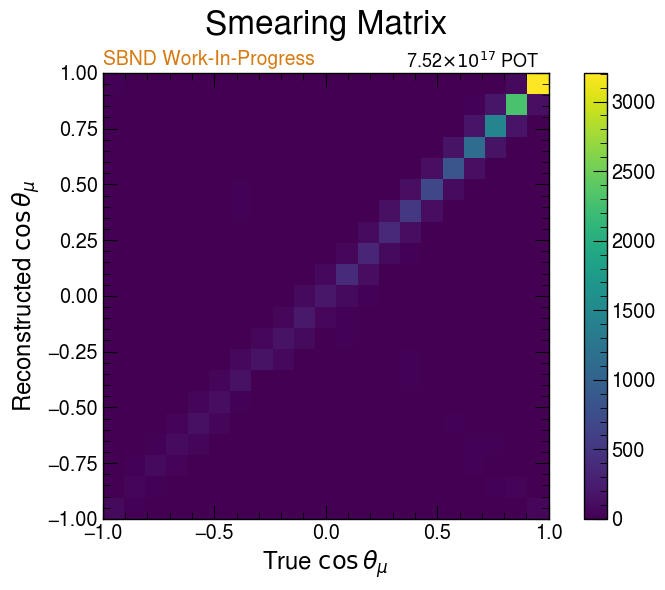

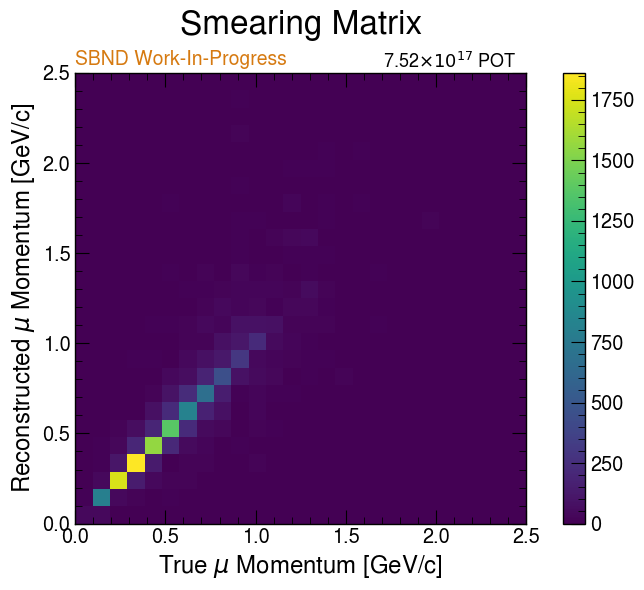

In [196]:
fig,ax = plotters.plot_square_with_bins(costheta_smearing,costheta_bin_edges,
  title=r'Smearing Matrix',axis_labels=[r'True $\cos\theta_{\mu}$',r'Reconstructed $\cos\theta_{\mu}$'])
utilities.mark_pot(ax,POT,horizontal=True)
utilities.mark_preliminary(ax,STATUS_LABEL)
fig.savefig(f'{SMEARING_OUTPUT_DIR}/reco_costheta_smearing.png')
plt.show()

fig,ax = plotters.plot_square_with_bins(momentum_smearing,momentum_bin_edges,
  title=r'Smearing Matrix',axis_labels=[r'True $\mu$ Momentum [GeV/c]',r'Reconstructed $\mu$ Momentum [GeV/c]'])
utilities.mark_pot(ax,POT,horizontal=True)
utilities.mark_preliminary(ax,STATUS_LABEL)
fig.savefig(f'{SMEARING_OUTPUT_DIR}/reco_momentum_smearing.png')
plt.show()

### 2.4 Response Matrix

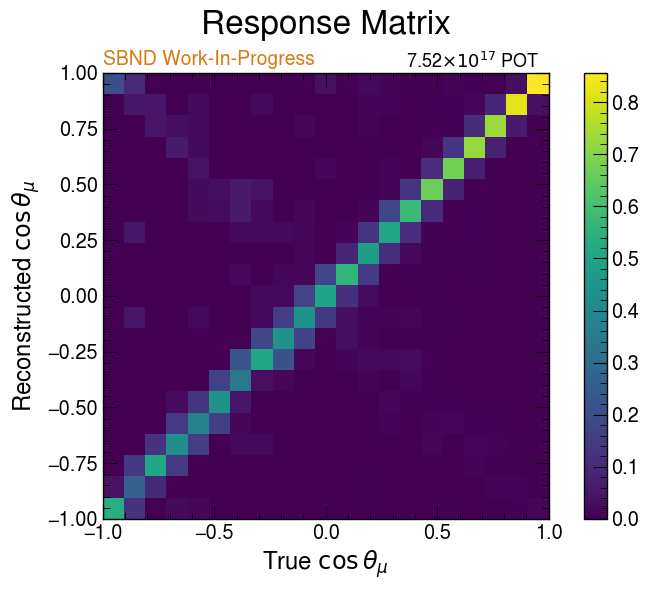

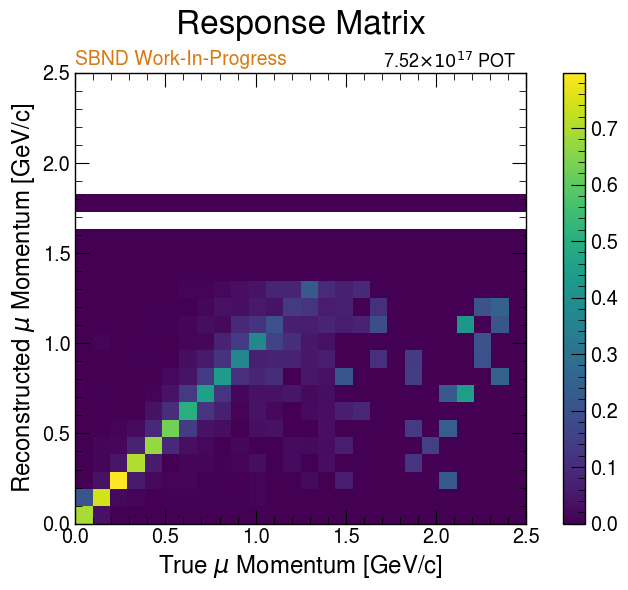

In [197]:
fig,ax = plotters.plot_square_with_bins(costheta_response,
  costheta_bin_edges,
  title=r'Response Matrix',axis_labels=[r'True $\cos\theta_{\mu}$',r'Reconstructed $\cos\theta_{\mu}$'])
utilities.mark_pot(ax,POT,horizontal=True)
utilities.mark_preliminary(ax,STATUS_LABEL)
fig.savefig(f'{SMEARING_OUTPUT_DIR}/reco_costheta_response.png')
plt.show()

fig,ax = plotters.plot_square_with_bins(momentum_response,
  momentum_bin_edges,
  title=r'Response Matrix',axis_labels=[r'True $\mu$ Momentum [GeV/c]',r'Reconstructed $\mu$ Momentum [GeV/c]'])
utilities.mark_pot(ax,POT,horizontal=True)
utilities.mark_preliminary(ax,STATUS_LABEL)
fig.savefig(f'{SMEARING_OUTPUT_DIR}/reco_momentum_response.png')
plt.show()

### 2.5 Flux

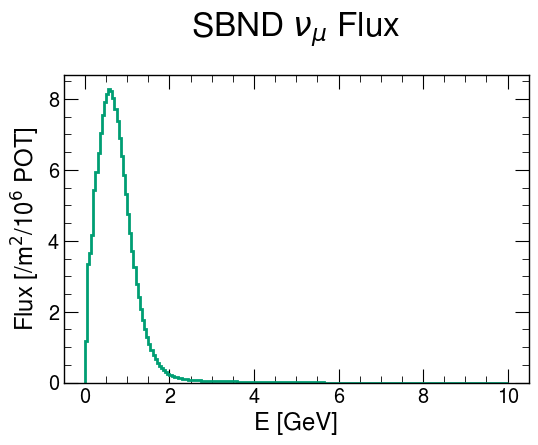

In [198]:
fig,ax = plt.subplots(figsize=(6,4))
ax.hist(bin_edges[:-1], bins=bin_edges, weights=flux_vals, histtype="step")
ax.set_xlabel("E [GeV]")
ax.set_ylabel("Flux [/m$^{2}$/10$^{6}$ POT]")
ax.set_title("SBND $\\nu_\\mu$ Flux")
fig.savefig(f'{OUTPUT_DIR}/flux.png')
plt.show()

### 2.6 Signal and selected distributions

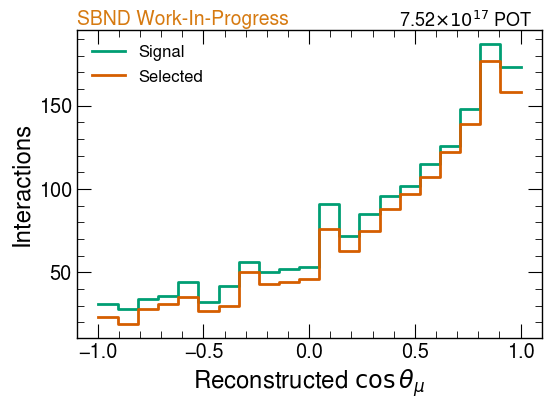

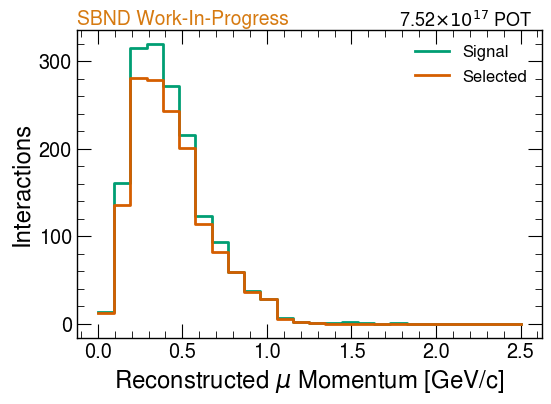

In [199]:
fig,ax = plt.subplots(figsize=(6,4))
plotters.plot_hist_edges(costheta_bin_edges,costheta_signal,None,'Signal',ax=ax)
plotters.plot_hist_edges(costheta_bin_edges,costheta_selected,None,'Selected',ax=ax)
ax.legend()
ax.set_xlabel(r'Reconstructed $\cos\theta_{\mu}$')
ax.set_ylabel(r'Interactions')
utilities.mark_pot(ax,POT,horizontal=True)
utilities.mark_preliminary(ax,STATUS_LABEL)
fig.savefig(f'{OUTPUT_DIR}/costheta_candidates.png')
plt.show()

fig,ax = plt.subplots(figsize=(6,4))
plotters.plot_hist_edges(momentum_bin_edges,momentum_signal,None,'Signal',ax=ax)
plotters.plot_hist_edges(momentum_bin_edges,momentum_selected,None,'Selected',ax=ax)
ax.legend()
ax.set_xlabel(r'Reconstructed $\mu$ Momentum [GeV/c]')
ax.set_ylabel(r'Interactions')
utilities.mark_pot(ax,POT,horizontal=True)
utilities.mark_preliminary(ax,STATUS_LABEL)
fig.savefig(f'{OUTPUT_DIR}/momentum_candidates.png')
plt.show()

In [289]:
import math
k = 18
l = 20
l**k*np.exp(-l)/math.factorial(k)

np.float64(0.08439355152248096)

## 3. Closure test

In [242]:
CLOSURE_OUTPUT_DIR = f'{OUTPUT_DIR}/closure'
os.makedirs(CLOSURE_OUTPUT_DIR,exist_ok=True)

### 3.1 Unfolding

In [243]:
costheta_cov_dumb = np.eye(len(costheta_selected))*costheta_selected

In [268]:
costheta_data = costheta_selected.copy() #use the central value as the data
costheta_smearing_dumb = costheta_smearing/costheta_smearing.sum(axis=0)
costheta_unfold_dict = wienersvd.WienerSVD(costheta_response,
  costheta_signal,
  costheta_data,
  #np.rot90(costheta_cov_dumb),
  #costheta_cov_dumb,
  #np.rot90(summary_covs['stat','reco_leading_muon_costheta']),
  summary_covs['stat','reco_leading_muon_costheta'],
  C_type=C_type,Norm_type=Norm_type)
print(C_type,Norm_type)

momentum_data = momentum_selected.copy() #use the central value as the data
# Convert everything to xsec units
# momentum_unfold_dict = wienersvd.WienerSVD(momentum_smearing,
#   momentum_signal,
#   momentum_data,
#   summary_covs['stat','reco_leading_muon_momentum_gev'],
#   C_type=C_type,Norm_type=Norm_type)


2 0.5


In [276]:
# Smear the model with the smearing matrix
costheta_signal_smear = costheta_unfold_dict['AddSmear'] @ costheta_signal
costheta_selected_smear = costheta_unfold_dict['AddSmear'] @ costheta_selected
#momentum_signal_smear = unfold_dict['AddSmear'] @ momentum_signal

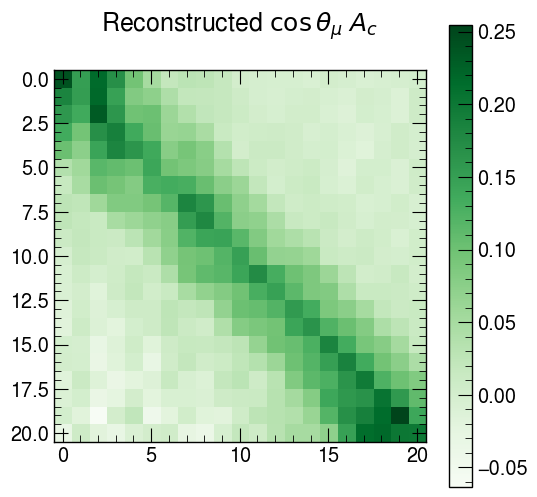

In [277]:
fig,ax = plt.subplots(figsize=(6,6))
im = ax.imshow(costheta_unfold_dict['AddSmear'])
ax.set_title(r'Reconstructed $\cos\theta_{\mu}$ $A_c$',fontsize=18)
fig.colorbar(im,ax=ax)
plt.show()
fig.savefig(f'{CLOSURE_OUTPUT_DIR}/reco_costheta_ac.png')

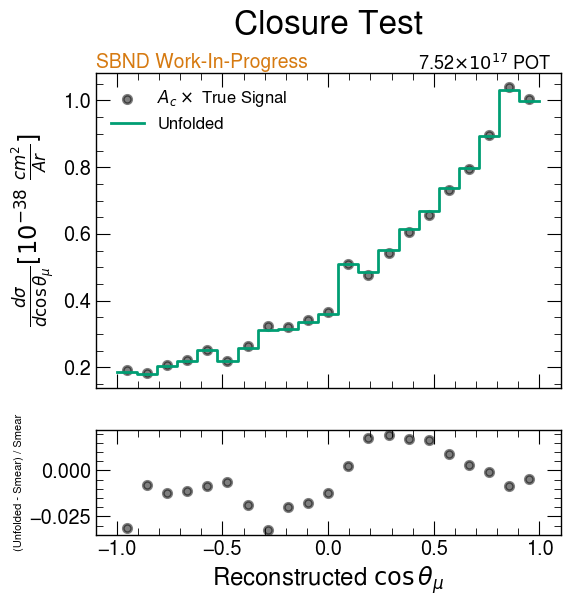

In [279]:
smear = costheta_signal_smear*XSEC_UNIT*1e38
smear_selected = costheta_selected_smear*XSEC_UNIT*1e38
signal = costheta_signal*XSEC_UNIT*1e38
unfold = costheta_unfold_dict['unfold']*XSEC_UNIT*1e38

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(6,6),sharex=True,height_ratios=[3,1])
#plotters.plot_hist_edges(costheta_bin_edges,costheta_data*XSEC_UNIT*1e38,None,'Data',ax=ax)
#plotters.plot_hist_edges(costheta_bin_edges,costheta_signal*XSEC_UNIT*1e38,None,'Signal',ax=ax)
ax1.scatter(costheta_bin_centers,smear, label='$A_c \\times$ True Signal',color='black',alpha=0.5)
plotters.plot_hist_edges(costheta_bin_edges,unfold,None,'Unfolded',ax=ax1)
ax1.legend()
#ax1.set_xlabel(r'Reconstructed $\cos\theta_{\mu}$')
ax1.set_title('Closure Test')
utilities.mark_pot(ax1,POT,horizontal=True)
utilities.mark_preliminary(ax1,STATUS_LABEL)
ax1.set_ylabel(r'$\frac{d\sigma}{d\cos\theta_{\mu}} [10^{-38} \ \frac{cm^2}{Ar}]$')

ax2.scatter(costheta_bin_centers,
  (unfold-smear)/smear,
  color='black',alpha=0.5)
ax2.set_xlabel(r'Reconstructed $\cos\theta_{\mu}$')
ax2.set_ylabel(r'(Unfolded - Smear) / Smear',fontsize=8)
fig.savefig(f'{OUTPUT_DIR}/costheta_closure_test.png')

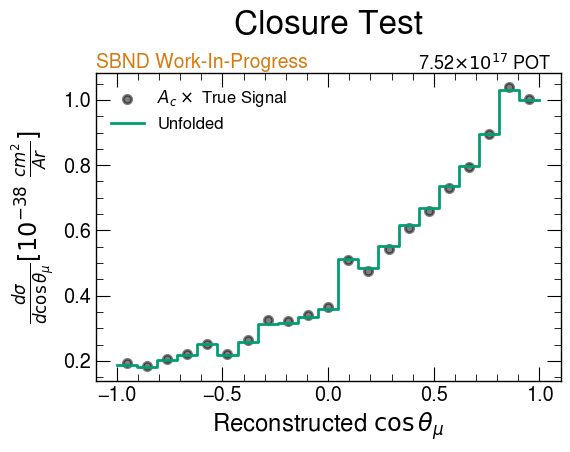

In [272]:
fig,ax = plt.subplots(figsize=(6,4))
#plotters.plot_hist_edges(costheta_bin_edges,costheta_data*XSEC_UNIT*1e38,None,'Data',ax=ax)
#plotters.plot_hist_edges(costheta_bin_edges,costheta_signal*XSEC_UNIT*1e38,None,'Signal',ax=ax)
ax.scatter(costheta_bin_centers,costheta_signal_smear*XSEC_UNIT*1e38, label='$A_c \\times$ True Signal',color='black',alpha=0.5)
plotters.plot_hist_edges(costheta_bin_edges,costheta_unfold_dict['unfold']*XSEC_UNIT*1e38,None,'Unfolded',ax=ax)
ax.legend()
ax.set_xlabel(r'Reconstructed $\cos\theta_{\mu}$')
ax.set_ylabel(r'$\frac{d\sigma}{d\cos\theta_{\mu}} [10^{-38} \ \frac{cm^2}{Ar}]$')
ax.set_title('Closure Test')
utilities.mark_pot(ax,POT,horizontal=True)
utilities.mark_preliminary(ax,STATUS_LABEL)
#fig.savefig(f'{COV_OUTPUT_DIR}/reco_costheta_unfold.png')
plt.show()

## X. Testing for dumbbies (ME)

In [76]:
import helpers
ind = 40
helpers.extract_parameter_name(summary_csvs[ind],variables),summary_csvs[ind]

(('all', 'reco_leading_muon_momentum_gev'),
 'all_reco_leading_muon_momentum_gev_fracuncs.csv')

In [9]:
frac_uncs = np.loadtxt(f'{SYST_DIR}/pioninexsec_Flux_reco_leading_muon_momentum_gev_fracuncs.csv')
cv = np.loadtxt(f'{SYST_DIR}/pioninexsec_Flux_reco_leading_muon_momentum_gev_cv.csv')
bin_edges = np.loadtxt(f'{SYST_DIR}/pioninexsec_Flux_reco_leading_muon_momentum_gev_bin_edges.csv')
cov = np.loadtxt(f'{SYST_DIR}/pioninexsec_Flux_reco_leading_muon_momentum_gev_cov.csv', delimiter=',')

([<matplotlib.lines.Line2D at 0x7f082cef31c0>],
 <ErrorbarContainer object of 3 artists>)

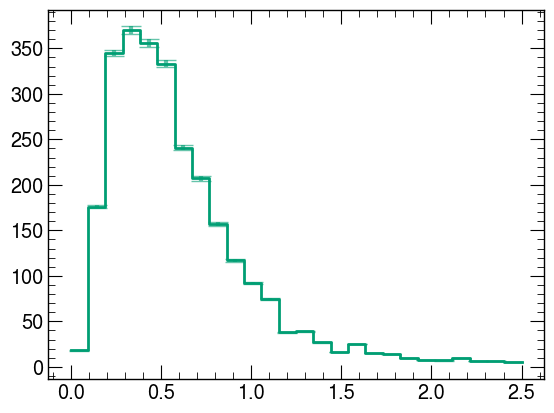

In [11]:
import plotters
plotters.plot_hist_edges(bin_edges, cv, frac_uncs*cv, '')

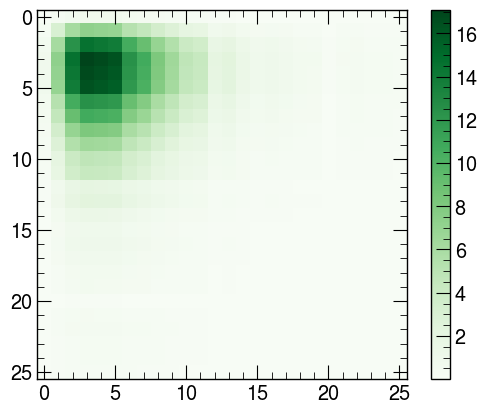

In [13]:
plt.imshow(cov)
plt.colorbar()
plt.show()